In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


 LOAD DATASET

In [25]:
# Load dataset
df = pd.read_csv('diabetes.csv')

# Copy dataset untuk pemrosesan
dataset = df.copy()

# Lihat beberapa data pertama
print(dataset.head())

# Ukuran dataset
print("Dataset shape:", dataset.shape)

# Periksa jumlah data duplikat
print("Jumlah duplikat:", dataset.duplicated().sum())

# Periksa missing values
print("Missing values per kolom:\n", dataset.isnull().sum())


   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  
Dataset shape: (768, 9)
Jumlah duplikat: 0
Missing values per kolom:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                    

In [8]:
from scipy import stats

kolom_numerik = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
                 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Menghapus outliers berdasarkan Z-Score (>3)
dataset = dataset[(np.abs(stats.zscore(dataset[kolom_numerik])) < 3).all(axis=1)]

# Cek ukuran dataset setelah menghapus outlier
print("Dataset setelah menghapus outlier:", dataset.shape)


Dataset setelah menghapus outlier: (688, 9)


In [26]:
X = dataset.drop(columns=["Outcome"])  # Semua kolom kecuali target
y = dataset["Outcome"]  # Kolom target

# Cek distribusi kelas sebelum SMOTE
print("Distribusi sebelum SMOTE:\n", y.value_counts())


Distribusi sebelum SMOTE:
 Outcome
0    500
1    268
Name: count, dtype: int64


Distribusi setelah SMOTE:
 Outcome
1    461
0    461
Name: count, dtype: int64


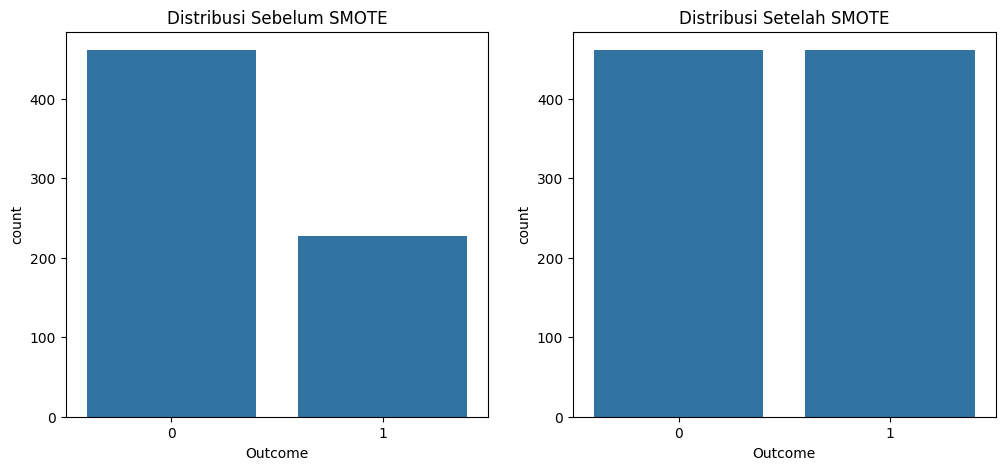

In [10]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Cek distribusi kelas setelah SMOTE
print("Distribusi setelah SMOTE:\n", y_resampled.value_counts())

# Visualisasi distribusi kelas
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x=y, ax=ax[0])
ax[0].set_title("Distribusi Sebelum SMOTE")
sns.countplot(x=y_resampled, ax=ax[1])
ax[1].set_title("Distribusi Setelah SMOTE")
plt.show()


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,
                                                    test_size=0.3,
                                                    random_state=42,
                                                    stratify=y_resampled)

print('Train set size :', X_train.shape, y_train.shape)
print('Test set size  :', X_test.shape, y_test.shape)


Train set size : (645, 8) (645,)
Test set size  : (277, 8) (277,)


In [12]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [13]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [14]:
hyperparameters = {
    'C': [0.1, 1, 10, 100, 1000],
    'kernel': ['rbf', 'sigmoid'],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001]
}

model_svm = GridSearchCV(SVC(), hyperparameters, cv=8, refit=True)
model_svm.fit(X_train_scaled, y_train)

print('Setting model SVM terbaik:', model_svm.best_params_)


Setting model SVM terbaik: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}


In [15]:
y_pred = model_svm.predict(X_test_scaled)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.82      0.79      0.81       139
           1       0.80      0.83      0.81       138

    accuracy                           0.81       277
   macro avg       0.81      0.81      0.81       277
weighted avg       0.81      0.81      0.81       277



In [16]:
y_pred = model_svm.predict(X_test_scaled)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.82      0.79      0.81       139
           1       0.80      0.83      0.81       138

    accuracy                           0.81       277
   macro avg       0.81      0.81      0.81       277
weighted avg       0.81      0.81      0.81       277



In [17]:
# Data input contoh (harus sesuai jumlah fitur yang dilatih)
input_data = (6,148,72,35,0,33.6,0.627,50)

# Konversi ke numpy array
input_data_as_numpy_array = np.array(input_data)

# Reshape data agar sesuai dengan input model
input_data_reshape = input_data_as_numpy_array.reshape(1, -1)

# Standardisasi input data
std_data = scaler.transform(input_data_reshape)

# Prediksi menggunakan model SVM
prediction = model_svm.predict(std_data)

# Output hasil prediksi
if prediction[0] == 1:
    print('Pasien terkena diabetes')
else:
    print('Pasien tidak terkena diabetes')


Pasien terkena diabetes


C:\Users\Acer\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


SIMPAN MODEL

In [19]:
import joblib
joblib.dump(model_svm, "diabetes_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("Model dan Scaler berhasil disimpan!")


Model dan Scaler berhasil disimpan!
